In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('../data/survival.csv', index_col = 0)

In [3]:
# data = pd.read_csv('../data/survival_clean.csv', index_col = 0)
data.head(4)

,id,study,rx,sex,age,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time,etype
1,1,1,Lev+5FU,1,43,0,0,0,5.0,1,2.0,3,0,1,1521,2
2,1,1,Lev+5FU,1,43,0,0,0,5.0,1,2.0,3,0,1,968,1
3,2,1,Lev+5FU,1,63,0,0,0,1.0,0,2.0,3,0,0,3087,2
4,2,1,Lev+5FU,1,63,0,0,0,1.0,0,2.0,3,0,0,3087,1


In [4]:
X = data.drop(['id','study','etype'], axis = 1)

In [5]:
X.head()

,rx,sex,age,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time
1,Lev+5FU,1,43,0,0,0,5.0,1,2.0,3,0,1,1521
2,Lev+5FU,1,43,0,0,0,5.0,1,2.0,3,0,1,968
3,Lev+5FU,1,63,0,0,0,1.0,0,2.0,3,0,0,3087
4,Lev+5FU,1,63,0,0,0,1.0,0,2.0,3,0,0,3087
5,Obs,0,71,0,0,1,7.0,1,2.0,2,0,1,963


In [6]:
X.groupby(['rx']).sex.agg(['count'])

,count
rx,
Lev,620
Lev+5FU,608
Obs,630


Zamieniam zmienną 'rx' na zmienną kategoryczną, 'Obs' = 0, 'Lev'=1, 'Lev+FU'=2

In [9]:
X['treatment'] = np.where(X['rx']=='Obs', 0, np.where(X['rx']=='Lev',1,2))

In [10]:
X.head()

,rx,sex,age,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time,treatment
1,Lev+5FU,1,43,0,0,0,5.0,1,2.0,3,0,1,1521,2
2,Lev+5FU,1,43,0,0,0,5.0,1,2.0,3,0,1,968,2
3,Lev+5FU,1,63,0,0,0,1.0,0,2.0,3,0,0,3087,2
4,Lev+5FU,1,63,0,0,0,1.0,0,2.0,3,0,0,3087,2
5,Obs,0,71,0,0,1,7.0,1,2.0,2,0,1,963,0


In [11]:
X.drop('rx', axis=1, inplace = True)

In [13]:
X = X.fillna(-1)

In [14]:
XX = X.drop(['treatment','time'], axis=1)
y = X['time']
treatment = X['treatment']

##  Uplift Random forest

In [16]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRegressor

# LRSRegressor

In [33]:
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(XX, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 9.67 (-46.58, 65.91)


In [40]:
lr_tau = lr.fit_predict(XX, treatment, y)
lr.get_importance(X=XX, 
                        tau=lr_tau,
                        normalize=True, 
                        method='auto',
                        features=XX.columns)

{1: age         0.6
 perfor      0.4
 node4       0.0
 surg        0.0
 extent      0.0
 differ      0.0
 status      0.0
 nodes       0.0
 adhere      0.0
 obstruct    0.0
 sex         0.0
 dtype: float64,
 2: sex        NaN
 age        NaN
 obstruct   NaN
 perfor     NaN
 adhere     NaN
 nodes      NaN
 status     NaN
 differ     NaN
 extent     NaN
 surg       NaN
 node4      NaN
 dtype: float64}

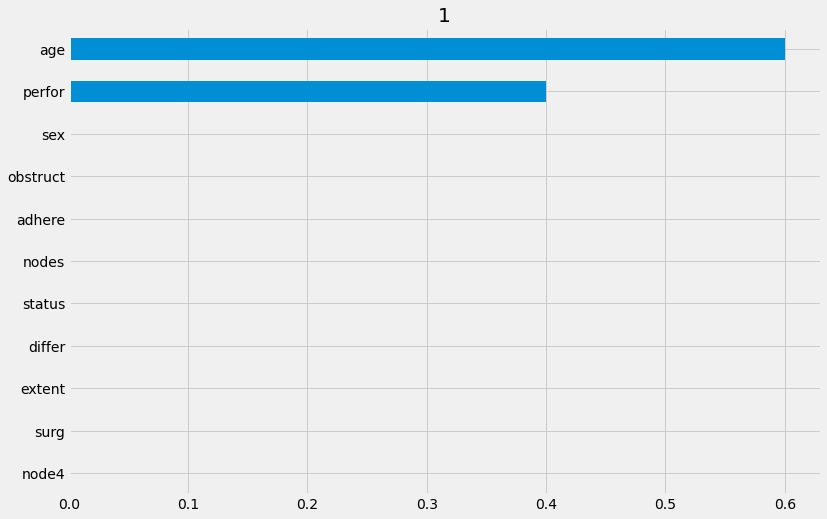

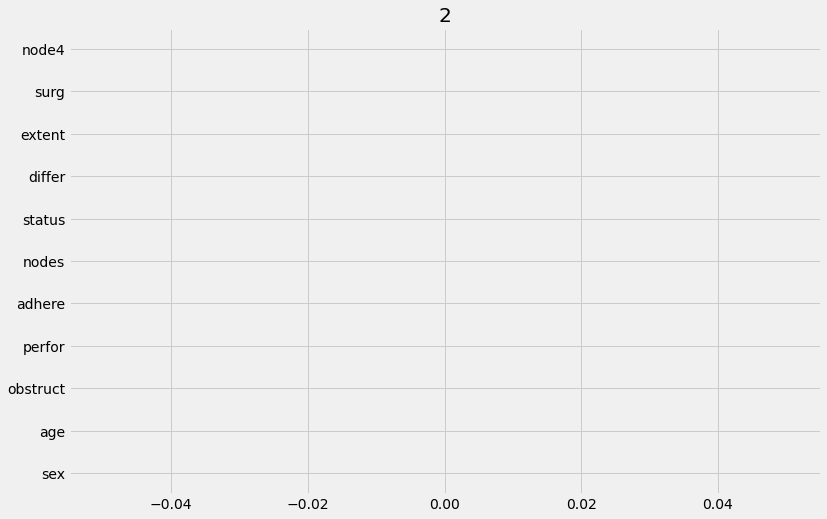

In [44]:
lr.plot_importance(X=XX, 
                         tau=lr_tau, 
                         normalize=True, 
                         method='auto', 
                         features=XX.columns)

# XGBRegressor

In [17]:
xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(XX, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (XGBoost): 7.77 (-34.04, 49.57)


In [19]:
# import pickle

In [20]:
# pickle.dump(xg, open('XGBTRegressor.pickle', 'wb'))

In [18]:
xg_tau = xg.fit_predict(XX, treatment, y)
xg.get_importance(X=XX, 
                        tau=xg_tau,
                        normalize=True, 
                        method='auto',
                        features=XX.columns)

{1: age         0.420134
 nodes       0.192335
 status      0.088878
 sex         0.065853
 surg        0.054820
 differ      0.046546
 node4       0.042395
 extent      0.041839
 adhere      0.023986
 obstruct    0.020866
 perfor      0.002349
 dtype: float64,
 2: age         0.394824
 nodes       0.182406
 status      0.106580
 surg        0.090350
 sex         0.074446
 extent      0.050201
 differ      0.047252
 obstruct    0.020519
 node4       0.018285
 adhere      0.012803
 perfor      0.002333
 dtype: float64}

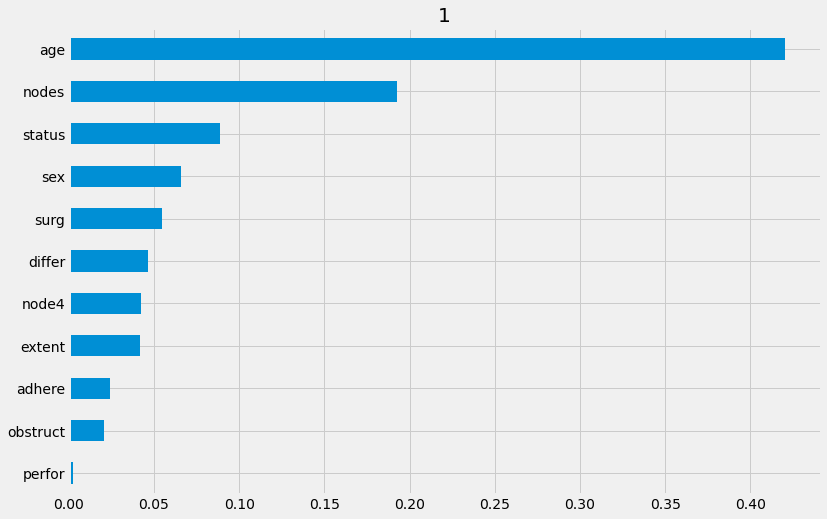

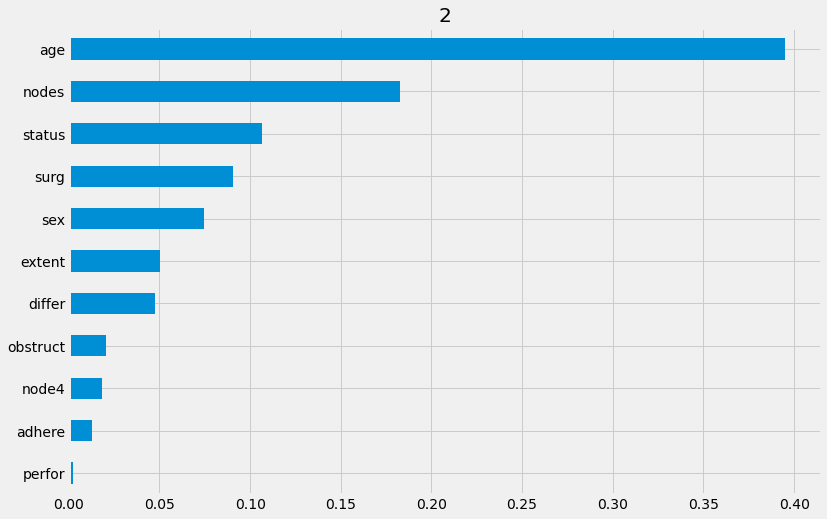

In [45]:
xg.plot_importance(X=XX, 
                         tau=xg_tau, 
                         normalize=True, 
                         method='auto', 
                         features=XX.columns)

In [49]:
shap_xg = xg.get_shap_values(X=XX, tau=xg_tau)

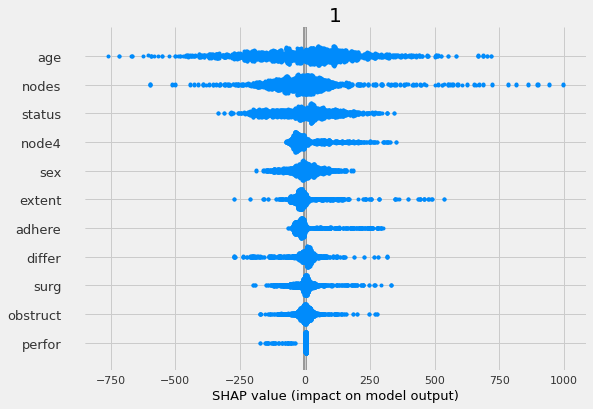

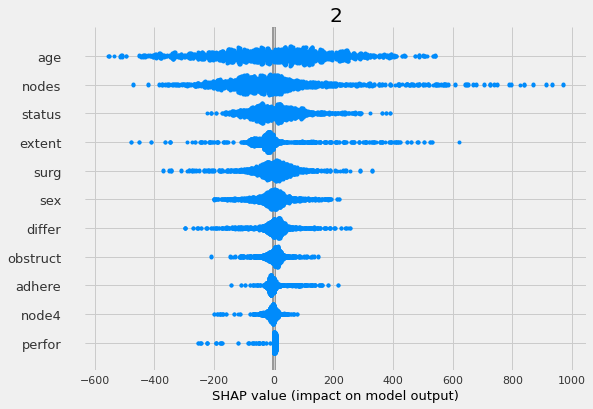

In [47]:
xg.plot_shap_values(X=XX, tau=xg_tau, features=XX.columns)

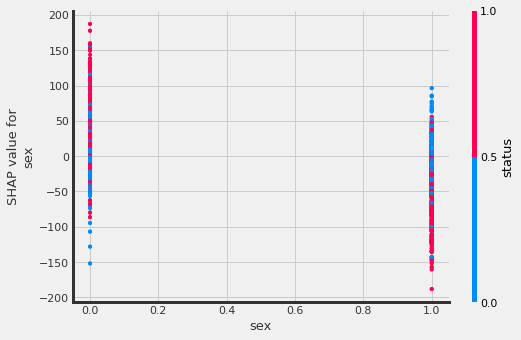

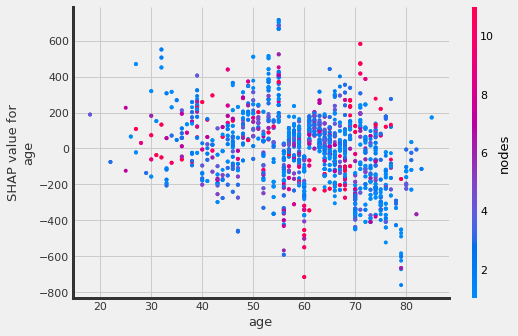

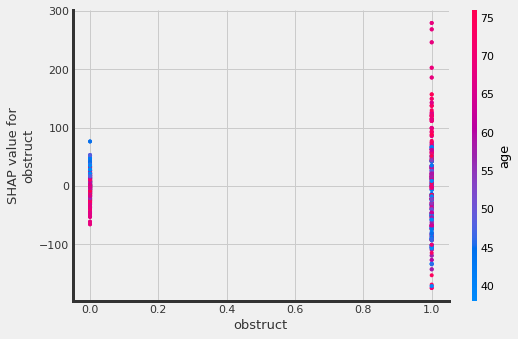

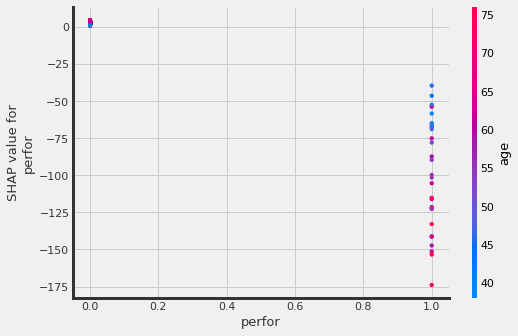

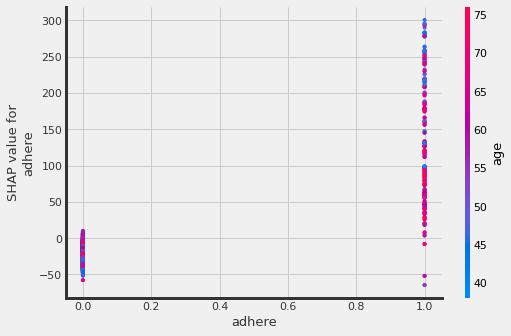

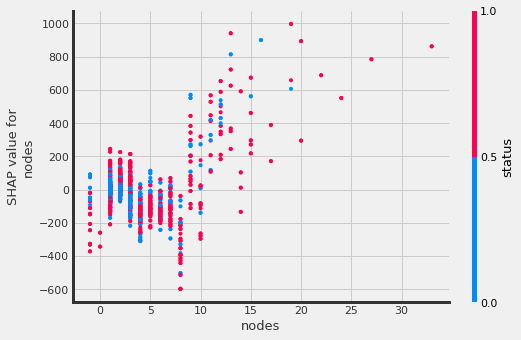

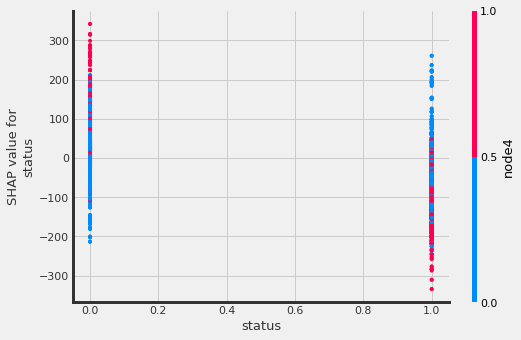

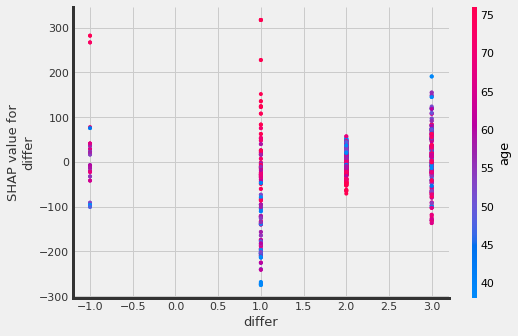

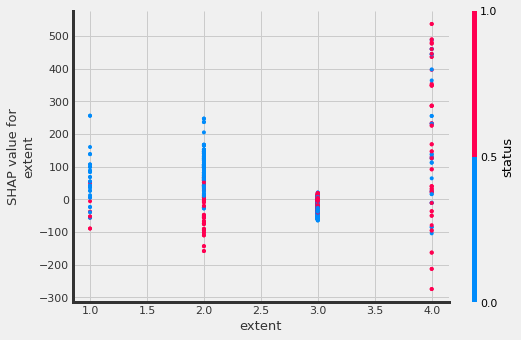

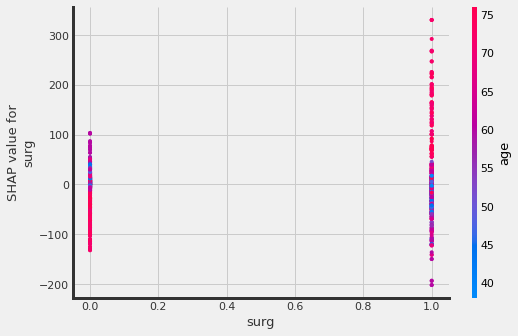

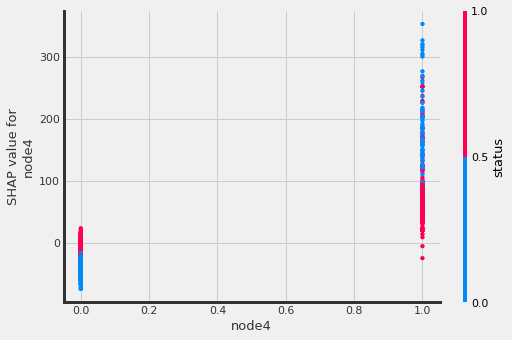

In [56]:
for feature in XX.columns:
    xg.plot_shap_dependence(treatment_group=1,
                              feature_idx=feature,
                              X=XX,
                              tau=xg_tau,
                              interaction_idx='auto',
                              shap_dict=shap_xg,
                              features=XX.columns)

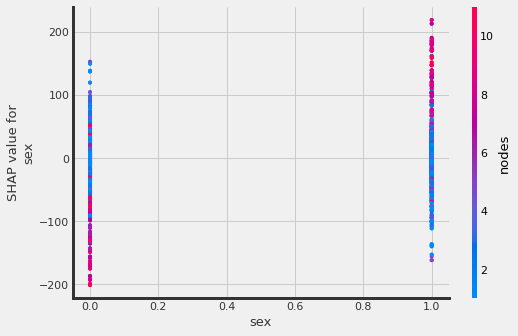

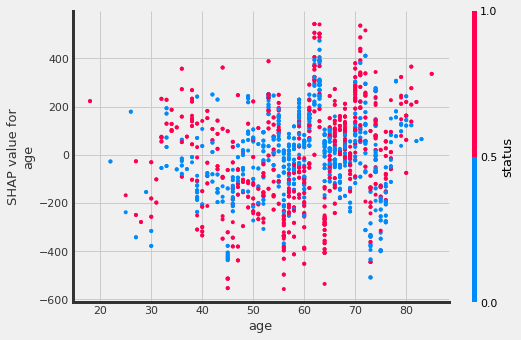

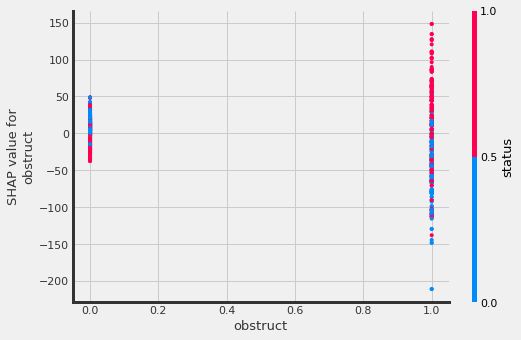

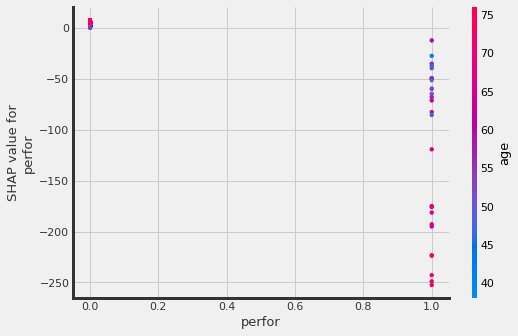

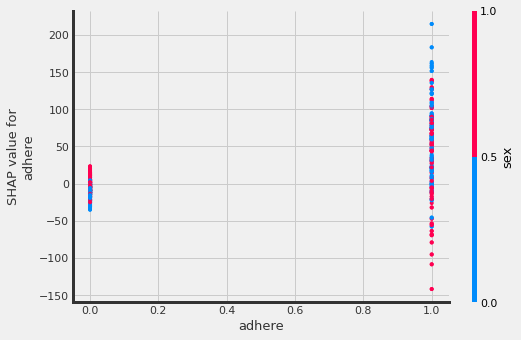

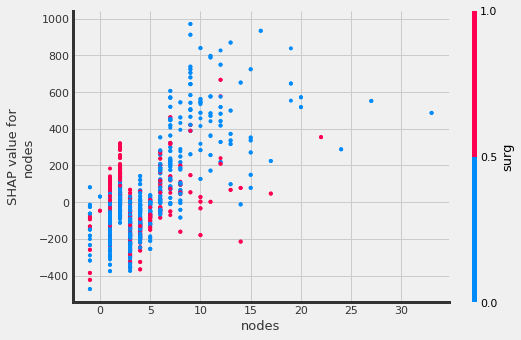

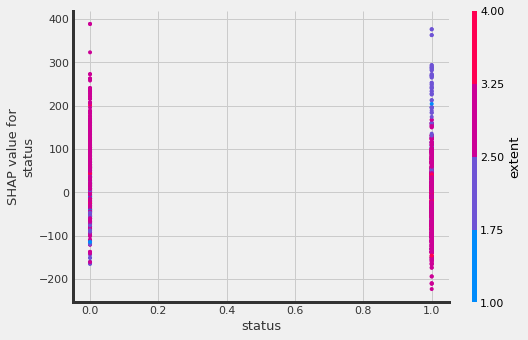

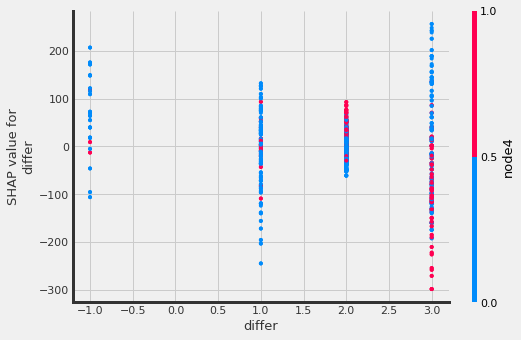

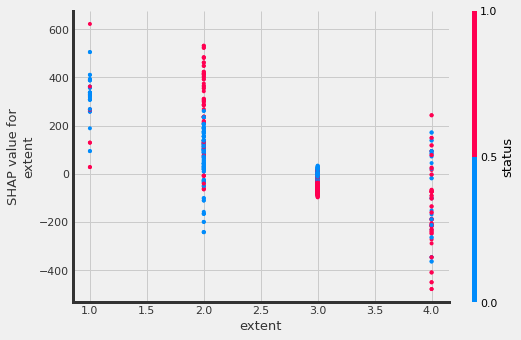

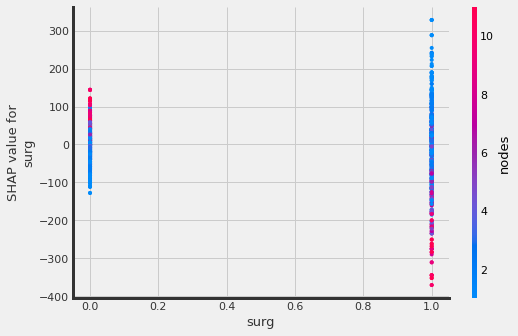

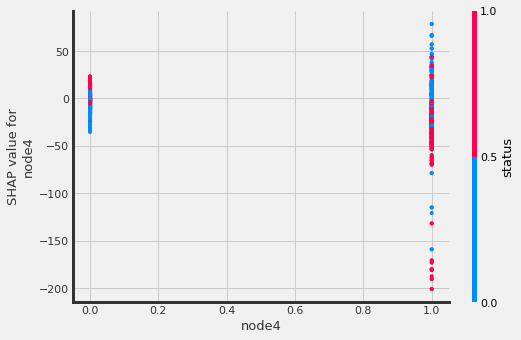

In [57]:
for feature in XX.columns:
    xg.plot_shap_dependence(treatment_group=2,
                              feature_idx=feature,
                              X=XX,
                              tau=xg_tau,
                              interaction_idx='auto',
                              shap_dict=shap_xg,
                              features=XX.columns)

In [36]:
nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(XX, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Neural Network (MLP)): -2.38 (-63.70, 58.94)


In [42]:
nn_tau = nn.fit_predict(XX, treatment, y)
nn.get_importance(X=XX, 
                        tau=nn_tau,
                        normalize=True, 
                        method='auto',
                        features=XX.columns)

{1: adhere      0.277481
 nodes       0.222677
 age         0.150901
 extent      0.087053
 status      0.084989
 node4       0.054419
 differ      0.042550
 surg        0.031737
 obstruct    0.029545
 sex         0.014311
 perfor      0.004339
 dtype: float64,
 2: nodes       0.385700
 obstruct    0.269702
 status      0.104507
 sex         0.089568
 surg        0.049171
 node4       0.030896
 age         0.022684
 perfor      0.019459
 extent      0.012183
 adhere      0.011161
 differ      0.004969
 dtype: float64}

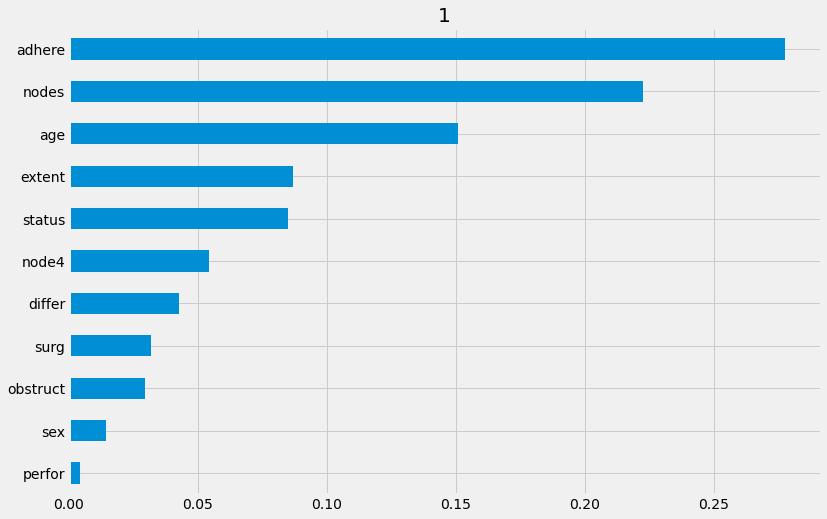

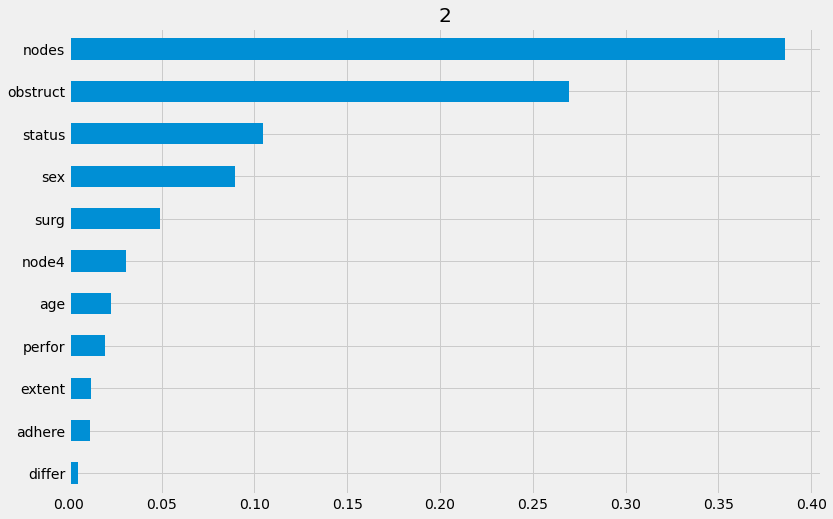

In [46]:
nn.plot_importance(X=XX, 
                         tau=nn_tau, 
                         normalize=True, 
                         method='auto', 
                         features=XX.columns)